## PRESCAL Updating Design

Original work: https://github.com/dongwookim-ml/almc  
Paper: https://arxiv.org/pdf/1608.05921.pdf

To speed up the algorithm, we re-design the updating steps.

We consider:

1. We might do not need to update posteriors for all entities and relations.

2. For a sequential updating algorithm (Thompson sampling), it doesn't make sense to use all observed labels in each iteration. i.e.

$$P_t = l({x}_t) P_{t-1}$$
where $x_t$ is the label observed in $t^{th}$ iteration.

Based on the above consideration, we come up with the following design ideas:

### Design 1

Assume we observe $x_{ijk}$ in $t^{th}$ iteration, we only update the posterior of $e_i, e_j, r_k$ using the new label $x_{ijk}$.

$\textbf{Prior}$:

$$P(\mathbf{e_i}|\sigma_e) = \mathcal{N}(\mathbf{e_i}| \mathbf{u_e}, {\sigma_e}^2 I_D)$$
$$P(\mathbf{R_k}|\sigma_r) = \mathcal{MN}(\mathbf{R_k}| \mathbf{u_r}, {\sigma_r} I_D, {\sigma_r} I_D)$$
or eqivalently,
$$P(\mathbf{r_k}|\sigma_r) = \mathcal{N}(\mathbf{r_k}| \mathbf{u_r}, {\sigma_r}^2 I_{D^2})$$
where $r_k = vec(R_k) \in \mathcal{R}^{D^2,1}$

$\textbf{Likelihood}$:

$$p(x_{ikj}|\mathbf{e_i, e_j}, R_k) = \mathcal{N}(x_{ikj}| \mathbf{e_i}^T R_k \mathbf{e_j}, \sigma_x^2)$$
using the identity $\mathbf{e_i}^T R_k \mathbf{e_j} = r_k^T \mathbf{e_i} \otimes \mathbf{e_j}$,
$$p(x_{ikj}|\mathbf{e_i, e_j, r_k}) = \mathcal{N}(x_{ikj}| \mathbf{r_k}^T \mathbf{e_i} \otimes \mathbf{e_j}, \sigma_x^2)$$

$\textbf{Entity Posterior}$:

$$P(\mathbf{e_i}|x_{ikj}, \mathbf{e_j}, R_k, \sigma_e) = \mathcal{N}(\mathbf{e_i}| m_{eN}, s_{eN}) \propto P(\mathbf{e_i}|\sigma_e)P(x_{ikj}|\mathbf{e_i, e_j}, R_k) = \mathcal{N}(\mathbf{e_i}| \mathbf{u_e}, {\sigma_e}^2 I_D) \mathcal{N}(x_{ikj}| \mathbf{e_i}^T R_k \mathbf{e_j}, \sigma_x^2)$$

We know for $c \mathcal{N}(\mathbf{x|c, C}) = \mathcal{N}(\mathbf{x|a, A})\mathcal{N}(\mathbf{x|b, B})$, 

\begin{equation}
\mathbf{C = {(A^{-1} + B ^{-1)})}^{-1}}
\end{equation}
$$\mathbf{c = C(A^{-1}a + B^{-1}b)}$$

So the goal is to transform $\mathcal{N}(x_{ikj}| r_k^T \mathbf{e_i} \otimes \mathbf{e_j}, \sigma_x^2)$ into $\mathcal{N}(\mathbf{e_i}|  M x_{ikj}, \sigma_x^2 MM^T)$

Assume $R_k \mathbf{e_j}$ is column full rank,
$$x_{ikj} = \mathbf{e_i^T}R_k\mathbf{e_j} \Leftrightarrow \mathbf{e_i} = (R_k \mathbf{e_j})^{-T}x_{ikj}$$

$$\mathcal{N}(\mathbf{e_i}|  M x_{ikj}, \sigma_x^2 MM^T) = \mathcal{N}(\mathbf{e_i}| (R_k \mathbf{e_j})^{-T}x_{ikj}, \sigma_x^2 ((R_k \mathbf{e_j})(R_k \mathbf{e_j})^T)^{-1})$$

$$s_{eN} = (\sigma_e^{-2} I_D +  \sigma_x^{-2} (R_k \mathbf{e_j})(R_k \mathbf{e_j})^T)^{-1}$$

$$m_{eN} = s_{eN} (\sigma_e^{-2} \mathbf{u_e} +  \sigma_x^{-2} (R_k \mathbf{e_j}) x_{ikj} )$$

Similarly, assum $\mathbf{e_i}^T R_k$ is column full rank, for $P(e_j|x_{ikj}, \mathbf{e_i}, R_k, \sigma_e)$ we have 

$$s_{eN} = (\sigma_e^{-2} I_D +  \sigma_x^{-2} (\mathbf{e_i}^T R_k)^T(\mathbf{e_i}^T R_k))^{-1}$$

$$m_{eN} = s_{eN} (\sigma_e^{-2} \mathbf{u_e} +  \sigma_x^{-2} (\mathbf{e_i}^T R_k)^T x_{ikj} )$$

$\textbf{Relation Posterior}:$

$$P(\mathbf{r_k}|x_{ikj}, \mathbf{e_i, e_j}, \sigma_r) = \mathcal{N}(\mathbf{r_k}|m_{rN}, s_{rN}) \propto P(\mathbf{r_k|\sigma_r})P(x_{ikj}|\mathbf{e_i, e_j, r_k}) = \mathcal{N}(\mathbf{r_k}| \mathbf{u_r}, {\sigma_r}^2 I_{D^2}) \mathcal{N}(x_{ikj}| \mathbf{r_k}^T \mathbf{e_i} \otimes \mathbf{e_j}, \sigma_x^2)$$

Similarly, assume $\mathbf{e_i} \otimes \mathbf{e_j}$ is column full rank,

$$ x_{ikj} = \mathbf{r_k}^T \mathbf{e_i} \otimes \mathbf{e_j} \Leftrightarrow \mathbf{r_k} = (\mathbf{e_i} \otimes \mathbf{e_j}) ^{-T} x_{ikj}$$ 

$$\mathcal{N}(\mathbf{r_k}|M x_{ikj}, \sigma^2 MM^T) = \mathcal{N}(\mathbf{r_k}| (\mathbf{e_i} \otimes \mathbf{e_j}) ^{-T} x_{ikj}, \sigma_x^{2} ((\mathbf{e_i} \otimes \mathbf{e_j}) (\mathbf{e_i} \otimes \mathbf{e_j}) ^T)^{-1} )$$

$$s_{rN} = (\sigma_r^{-2}I_D + \sigma_x^{-2} (\mathbf{e_i} \otimes \mathbf{e_j}) (\mathbf{e_i} \otimes \mathbf{e_j}) ^T)^{-1}$$ 

$$m_{rN} = s_{rN}(\sigma_r^{-2} \mathbf{u_r} + \sigma_x^{-2} (\mathbf{e_i} \otimes \mathbf{e_j})x_{ikj})$$

In [1]:
# direct to parent folder
import sys
sys.path.append("../acton")

from acton.database import GraphReader, GraphDatabase
from acton.predictors import TensorPredictor
from acton.recommenders import ThompsonSamplingRecommender
from acton.labellers import GraphDatabaseLabeller
import acton.acton
import tempfile
import astropy.io.ascii as io_ascii
import os.path
import numpy
import logging
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict

/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
logging.basicConfig(level = logging.DEBUG)

_path = 'kg-data/nation/triples.txt'
output_path = 'acton.proto'
outfile_path = "ts_update_one_exper4/"
n_dim = 10
TS= 0.0
RANDOM = 1.0

In [3]:
with GraphReader(_path, n_dim) as reader:
    n_relations = reader.n_relations
    n_entities = reader.n_entities
    totoal_size = n_relations * n_entities * n_entities
    ids = numpy.arange(totoal_size)
    
    N_EPOCHS = 5000
    repeated_labelling = True

    results = defaultdict(list)
      
    # rtrs: repeated train ROC-AUC-SCORE
    # rtes: repeated test ROC-AUC-SCORE
    # rg: repeated cumulative gain
    
    results['TS_rtrs'], results['TS_rtes'],\
    results['TS_rg'], results['time'], mean_r =  \
        acton.acton.simulate_active_learning(
            ids, reader, {}, output_path,
            n_epochs=N_EPOCHS,
            recommender='ThompsonSamplingRecommender',
            predictor='TensorPredictor',
            labeller='GraphDatabaseLabeller',
            diversity=TS,
            repeated_labelling=repeated_labelling,
            inc_sub = False,
            subn_entities = n_entities,
            subn_relations = n_relations,
            update_one = True
        )
       
    
    with open(outfile_path + 'outfile_update_one', 'wb') as fp:
        pickle.dump(results,fp) 

DEBUG:root:New feature E array size: (5, 14, 10)
DEBUG:root:New feature R array size: (5, 56, 10, 10)
DEBUG:root:New label array size: (56, 14, 14)
DEBUG:root:Found 10976 instances.
DEBUG:root:Splitting into training/testing sets.
DEBUG:root:Drawing initial labels.
DEBUG:root:Recommending: [(42, 11, 0), (22, 1, 10), (42, 3, 9), (46, 0, 3), (48, 8, 5), (43, 8, 7), (48, 0, 10), (11, 4, 0), (47, 9, 4), (28, 12, 5)]
DEBUG:root:Writing protobufs to acton.proto.
INFO:root:Epoch 1/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:update one: (28, 12, 5) using label: 1.0
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8770).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(22, 12, 7)]
INFO:root:Epoch 2/5000
DEBUG:root:Labelling recommendations.
DEBUG:r

INFO:root:Epoch 18/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (55, 4, 4) using label: 0.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8756).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(10, 5, 5)]
INFO:root:Epoch 19/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (10, 5, 5) using label: 0.0
DEBUG:root:(Took 0.012 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8755).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(10, 1, 1)]
INFO:root:Epoch 20/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEB

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 7, 7)]
INFO:root:Epoch 36/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:update one: (47, 7, 7) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00022 s.)
DEBUG:root:Making predictions (unlabelled, n = 8740).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(9, 13, 13)]
INFO:root:Epoch 37/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (9, 13, 13) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8739).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(10, 5, 0)]
INFO:root:Epoch 

DEBUG:root:Making predictions (unlabelled, n = 8726).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 9, 11)]
INFO:root:Epoch 54/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (42, 9, 11) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8725).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 12)]
INFO:root:Epoch 55/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 0 0 1 0]
DEBUG:root:update one: (44, 12, 12) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0022 s.)
DEBUG:root:Making predictions (unlabelled, n = 8724).
DEBUG:root:(Took 0.00072 s.)
DEBU

DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8709).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 13, 13)]
INFO:root:Epoch 72/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:update one: (47, 13, 13) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8709).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(51, 10, 10)]
INFO:root:Epoch 73/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (51, 10, 10) using label: 0.0
DEBUG:root:(Took 0.013 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8708).
D

DEBUG:root:(Took 0.012 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 8694).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(53, 10, 10)]
INFO:root:Epoch 90/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (53, 10, 10) using label: 0.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8693).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(10, 6, 2)]
INFO:root:Epoch 91/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 0 1 3 0]
DEBUG:root:update one: (10, 6, 2) using label: 0.0
DEBUG:root:(Took 0.013 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:

DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8677).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(23, 12, 10)]
INFO:root:Epoch 108/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (23, 12, 10) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predictions (unlabelled, n = 8676).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(24, 12, 12)]
INFO:root:Epoch 109/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:update one: (24, 12, 12) using label: 0.0
DEBUG:root:(Took 0.013 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8675

DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8662).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(16, 9, 9)]
INFO:root:Epoch 126/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (16, 9, 9) using label: 0.0
DEBUG:root:(Took 0.013 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making predictions (unlabelled, n = 8661).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(6, 9, 3)]
INFO:root:Epoch 127/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 3 2]
DEBUG:root:update one: (6, 9, 3) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8660).
DEBUG:ro

DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8650).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 12, 5)]
INFO:root:Epoch 144/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:update one: (47, 12, 5) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8649).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(13, 9, 12)]
INFO:root:Epoch 145/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 0 1 0 0]
DEBUG:root:update one: (13, 9, 12) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictio

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:update one: (51, 1, 1) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8634).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 12, 12)]
INFO:root:Epoch 162/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 12, 12) using label: 0.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8633).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(22, 12, 12)]
INFO:root:Epoch 163/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: 

DEBUG:root:Recommending: [(16, 7, 12)]
INFO:root:Epoch 179/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 3 2 0]
DEBUG:root:update one: (16, 7, 12) using label: 0.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8625).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 12)]
INFO:root:Epoch 180/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 12) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8625).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(14, 12, 12)]
INFO:root:Epoch 181/5000
DEBUG:root:Labelling 

DEBUG:root:Making predictions (unlabelled, n = 8612).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 7)]
INFO:root:Epoch 197/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:update one: (44, 12, 7) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8612).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(19, 7, 7)]
INFO:root:Epoch 198/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 0 0 3 0]
DEBUG:root:update one: (19, 7, 7) using label: 0.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predictions (unlabelled, n = 8611)

INFO:root:Epoch 214/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (21, 5, 5) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8603).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(1, 6, 5)]
INFO:root:Epoch 215/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 3 2]
DEBUG:root:update one: (1, 6, 5) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making predictions (unlabelled, n = 8602).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(16, 5, 6)]
INFO:root:Epoch 216/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs

DEBUG:root:Recommending: [(31, 9, 12)]
INFO:root:Epoch 232/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 0 2 0]
DEBUG:root:update one: (31, 9, 12) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8589).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(2, 9, 9)]
INFO:root:Epoch 233/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (2, 9, 9) using label: 0.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8588).
DEBUG:root:(Took 0.00061 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(52, 7, 6)]
INFO:root:Epoch 234/5000
DEBUG:root:Labelling recomm

DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(35, 12, 12)]
INFO:root:Epoch 250/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (35, 12, 12) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8575).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(16, 12, 3)]
INFO:root:Epoch 251/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 1 4 0]
DEBUG:root:update one: (16, 12, 3) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8574).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommend

DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making predictions (unlabelled, n = 8563).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 3, 12)]
INFO:root:Epoch 268/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 2 3]
DEBUG:root:update one: (25, 3, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8563).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(12, 12, 8)]
INFO:root:Epoch 269/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 3 2]
DEBUG:root:update one: (12, 12, 8) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predic

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:update one: (43, 12, 12) using label: 0.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making predictions (unlabelled, n = 8553).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 3, 12)]
INFO:root:Epoch 286/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:update one: (25, 3, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8553).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(29, 6, 8)]
INFO:root:Epoch 287/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting p

INFO:root:Epoch 303/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (2, 12, 0) using label: 0.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8541).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 0, 12)]
INFO:root:Epoch 304/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:update one: (25, 0, 12) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00028 s.)
DEBUG:root:Making predictions (unlabelled, n = 8541).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(12, 0, 0)]
INFO:root:Epoch 305/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label

DEBUG:root:Recommending: [(47, 12, 11)]
INFO:root:Epoch 321/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:update one: (47, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8530).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(18, 11, 11)]
INFO:root:Epoch 322/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (18, 11, 11) using label: 0.0
DEBUG:root:(Took 0.013 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8529).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 11)]
INFO:root:Epoch 323/5000
DEBUG:root:Labellin

DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8525).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 339/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8525).
DEBUG:root:(Took 0.00037 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 340/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 0 0 1 0]
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making pred

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00059 s.)
DEBUG:root:Making predictions (unlabelled, n = 8524).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 357/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8524).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 358/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update on

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 1 1 3 0]
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8524).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 375/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 8524).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 376/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update on

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 1 4]
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 393/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 394/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one

DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 411/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 412/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00061 s.)
DEBUG

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 429/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0015 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 430/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00029 s.)
DEBUG:root:Making recommendations.


DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 448/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 449/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update o

DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 466/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 467/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0006 s.)
DEB

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 484/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 485/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.02 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 486/5000
DEBUG:root:Label

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 503/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 504/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
D

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 521/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 522/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendation

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 540/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 541/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEB

DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 558/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 559/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00086 s.)
DEB

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 577/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 578/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBU

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 595/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 596/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (un

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 613/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.02 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 614/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 615/5000
DEBUG:root:Labe

DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 632/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00032 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 633/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:update one: (41, 11, 12) using label: 1.0

DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 650/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 651/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.013 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00076 s.)
DE

DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 668/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 669/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 670/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sor

DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 687/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.013 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 688/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:

DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 705/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 706/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Ep

DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 724/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0015 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 725/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 742/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 743/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0015 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 761/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 762/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
D

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 779/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 780/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
D

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 798/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 799/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
D

DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 816/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 817/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0008 s.)
DEBU

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 835/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 836/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:r

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 853/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 854/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendatio

DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 872/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 873/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 890/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 891/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendatio

DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00063 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 909/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 910/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBU

DEBUG:root:(Took 0.0006 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 927/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 928/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 3 2]
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recomme

DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 946/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00057 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 947/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (refer

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 964/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00056 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 965/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making recommendatio

DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 983/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 984/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1001/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1002/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendatio

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 1020/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1021/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBU

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 1038/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00051 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1039/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendat

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1057/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1058/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update

DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1075/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1076/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00081 s.)


INFO:root:Epoch 1093/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.013 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1094/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 1095/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting pr

DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00063 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1112/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1113/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)


INFO:root:Epoch 1130/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1131/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 1132/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting pre

DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1149/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1150/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00067 s.)
D

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 1168/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1169/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:upda

DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1186/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1187/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0011 s.)
DE

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1205/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1206/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0


DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1223/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 1224/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00068 s.)
D

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1242/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1243/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAM

DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1260/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 1261/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00021 s.)
DE

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1279/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 1280/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
D

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1297/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1298/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendati

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 1316/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1317/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
D

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1334/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00033 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1335/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendation

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0005 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1353/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1354/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0


DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1371/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1372/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making recommendation

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1390/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1391/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:upd

DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1408/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 1409/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00096 s.)
DEB

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1427/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1428/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
D

DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1445/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1446/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00082 s.)
DE

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 1464/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 1465/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:upd

DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1482/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1483/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.02 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0003 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00069 s.)
DE

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 1501/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1502/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:upd

DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 1519/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1520/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00066 s.)
DEBU

INFO:root:Epoch 1537/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1538/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0003 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1539/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting pr

DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1556/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.02 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 1557/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00051 s.)
DEBU

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 1575/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1576/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DE

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1593/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 1594/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making recommendat

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1612/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 1613/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG

DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1630/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1631/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00095 s.)
DEB

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 1649/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 1650/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DE

DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 1667/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1668/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00086 s.)


DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1686/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1687/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update

DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1704/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 1705/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00086 s.)
D

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1723/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1724/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update 

DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1741/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00041 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1742/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00081 s.)
DE

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1760/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1761/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:upd

DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1778/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1779/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.001 s.)
DEB

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00033 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1797/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.023 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0006 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1798/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0


DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 1815/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 1816/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.

DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 1834/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1835/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBU

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1852/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1853/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making recommendat

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 1871/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 1872/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 1889/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1890/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendat

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1908/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 1909/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0


DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1926/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1927/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendati

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1945/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1946/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1963/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1964/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendati

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1982/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0006 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 1983/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DE

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 2000/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2001/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations

DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2019/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2020/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DE

DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2037/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2038/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:

DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 2056/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2057/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (refe

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 2074/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2075/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 2076/5000
DEBUG:root:L

DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2093/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2094/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:

DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2111/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 2112/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2113/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:S

DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2130/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 2131/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBU

DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2148/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 2149/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.021 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2150/5000
DEBUG:root:Labelling recommendations.
DEBUG:ro

DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2167/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2168/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2185/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2186/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2187/5000
DEBUG:root:La

DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2204/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00027 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 2205/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBU

DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2222/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.02 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 2223/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2224/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00042 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 2241/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 2242/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions 

INFO:root:Epoch 2259/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2260/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2261/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting 

DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2278/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 2279/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00089 s.)
D

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 2297/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 2298/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update

DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2315/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2316/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00084 s.)


DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2334/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 2335/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:updat

DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2352/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 2353/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00058 s.)
DEB

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00043 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2371/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 2372/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
D

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2389/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 2390/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making recommendati

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00063 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2408/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2409/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2426/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00039 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2427/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendat

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2445/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 2446/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0


DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2463/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2464/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendatio

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2482/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0016 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2483/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DE

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2500/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2501/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making recommendation

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2519/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00058 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 2520/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2537/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 2538/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making recommendati

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2556/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2557/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEB

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2574/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 2575/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendat

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2593/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2594/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0


DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 2611/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 2612/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendatio

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2630/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00031 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2631/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0


DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2648/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2649/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00055 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making recommendation

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0015 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2667/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2668/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
D

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2685/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2686/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendat

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 2704/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2705/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0006 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2722/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00034 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 2723/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making recommendati

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2741/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2742/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2759/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.021 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2760/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendatio

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 2778/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2779/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
D

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2796/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2797/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendat

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 2815/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 2816/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2833/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2834/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendat

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2852/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00035 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 2853/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0


DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2870/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2871/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00036 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00053 s.)
DEBUG:root:Making recommendation

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2889/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2890/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0


DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 2907/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2908/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendation

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00063 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2926/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 2927/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2944/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00063 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2945/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendat

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2963/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2964/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
D

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2981/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 2982/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendation

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3000/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3001/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
D

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3018/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3019/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making recommendation

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0015 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3037/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3038/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
D

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 3055/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00047 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 3056/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendat

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3074/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00059 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3075/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3092/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3093/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendat

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3111/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 3112/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
D

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 3129/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3130/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making recommendat

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3148/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 3149/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3166/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3167/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendati

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 3185/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 3186/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0


DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3203/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3204/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendati

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3222/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 3223/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0


DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3240/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00059 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 3241/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendat

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 3259/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.013 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3260/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0


DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 3277/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 3278/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendation

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3296/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3297/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3314/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.013 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3315/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making recommendati

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0016 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3333/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 3334/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0


DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3351/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 3352/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.013 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making recommendat

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3370/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0006 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3371/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0


DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3388/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3389/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendatio

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 3407/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3408/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0


DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 3425/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 3426/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendati

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3444/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 3445/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0


DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3462/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3463/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00063 s.)
DEBUG:root:Making recommendat

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3481/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3482/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
D

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3499/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3500/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.013 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00063 s.)
DEBUG:root:Making recommendat

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3518/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3519/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 3536/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3537/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendat

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3555/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3556/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3573/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3574/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendation

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 3592/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00056 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 3593/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0


DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3610/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3611/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendat

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3629/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3630/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
D

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 3647/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 3648/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendat

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3666/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 3667/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DE

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3684/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3685/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendatio

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3703/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 3704/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3721/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3722/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendatio

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3740/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3741/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 3758/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3759/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendat

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3777/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 3778/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
D

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3795/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3796/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendat

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 3814/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.013 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3815/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3832/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3833/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendatio

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3851/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3852/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3869/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3870/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendatio

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0015 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3888/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 3889/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
D

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0015 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3906/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00058 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 3907/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendatio

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3925/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3926/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 3943/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 3944/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00046 s.)
DEBUG:root:Making recommendatio

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3962/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3963/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
D

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3980/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 3981/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendat

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 3999/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 4000/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
D

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4017/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4018/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendat

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4036/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 4037/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
D

DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 4054/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4055/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00065 s.)
DEBU

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4073/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4074/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:upd

DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 4091/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4092/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00055 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0008 s.)
D

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 4110/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4111/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0


DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4128/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4129/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making recommendati

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4147/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4148/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4165/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4166/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendatio

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0022 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4184/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4185/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0


DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 4202/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4203/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendat

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4221/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 4222/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0


DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4239/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4240/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendatio

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4258/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4259/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4276/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4277/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making recommendation

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4295/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4296/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4313/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4314/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendat

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4332/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4333/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0


DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 4350/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4351/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendati

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4369/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4370/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4387/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00058 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 4388/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.013 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendati

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00051 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4406/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00061 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4407/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0006 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4424/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4425/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendati

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00063 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4443/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4444/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4461/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 4462/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendation

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4480/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 4481/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
D

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4498/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 4499/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendat

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 4517/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 4518/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 4535/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4536/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendation

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00063 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 4554/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00063 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4555/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4572/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 4573/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendation

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4591/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4592/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0


DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 4609/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4610/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendation

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00046 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 4628/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4629/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0


DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00058 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 4646/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4647/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendati

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4665/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4666/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4683/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4684/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendat

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.013 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00051 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 4702/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4703/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0


DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4720/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 4721/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendat

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 4739/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4740/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 4757/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4758/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendation

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 4776/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4777/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0


DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00063 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4794/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00058 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4795/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendat

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 4813/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4814/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0


DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 4831/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.013 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4832/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making recommendat

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4850/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4851/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0


DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 4868/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4869/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making recommendation

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4887/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 4888/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 4905/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4906/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.0003 s.)
DEBUG:root:Making recommendati

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00061 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 4924/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4925/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 4942/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4943/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendat

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4961/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4962/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
D

DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 11)]
INFO:root:Epoch 4979/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 12, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4980/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendat

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 12)]
INFO:root:Epoch 4998/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 11, 12) using label: 1.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making predictions (unlabelled, n = 8523).
DEBUG:root:(Took 0.00063 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 4999/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 12) using label: 1.0


In [4]:
with open ('ts_subsampling_exper1/outfile_all', 'rb') as fp:
    results_all = pickle.load(fp)

with open (outfile_path + 'outfile_update_one', 'rb') as fp:
    results_one = pickle.load(fp)

In [5]:
# some rows of the mean_r are never updated!
for i in mean_r:
    print(i)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[ 0.19017598  0.39278823  0.41529278 -0.30640991  0.10600833 -0.08103388
  0.14027675  0.06060334  0.12464284  0.2194177   0.21521921  0.37584298
  0.39969447 -0.29205475  0.12944656 -0.04263336  0.13299734  0.07187785
  0.11613577  0.22035029 -0.10022621 -0.1497774  -0.15918428  0.10651566
 -0.058379    0.015974   -0.05214803 -0.0366404  -0.0402154  -0.08924575
 -0.0420048  -0.04480531 -0.05290477  0.03769436 -0.04254397 -0.00780523
 -0.01321844 -0.00262765 -0.01231801 -0.0312162   0.07861227  0.19478123
  0.20436597 -0.14770083  0.0267897  -0.07675485  0.0700737   0.02518505
  0.05121815  0.10573639 -0.1833534  -0.26507872 -0.26998155  0.19185215
 -0.1313613  -0.01591701 -0.08411051 

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


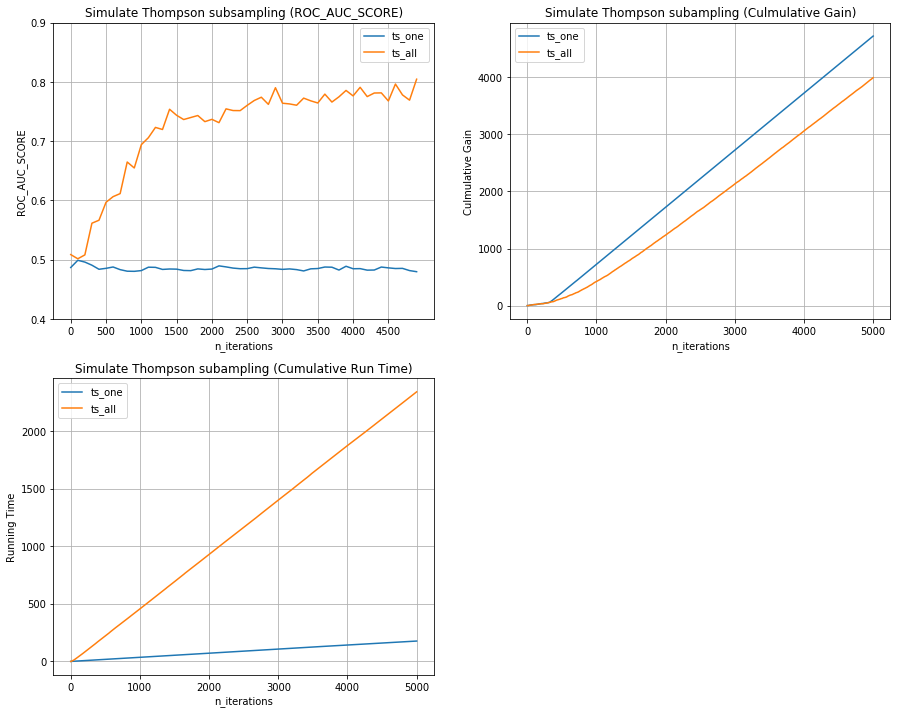

In [6]:
plt.figure(figsize= (15,12))

# only plot 2000 iterations for the purpose of comparison with unrepeated labelling
plt.subplot(221)
plt.plot(results_one['TS_rtrs'][::100], label = 'ts_one')
plt.plot(results_all['TS_rtrs100'][::100], label = 'ts_all')
plt.xticks(numpy.arange(50, step = 5), numpy.arange(5000)[::500])
plt.xlabel('n_iterations')
plt.ylabel('ROC_AUC_SCORE')
plt.ylim(0.4,0.9)
plt.title('Simulate Thompson subsampling (ROC_AUC_SCORE)')
plt.grid(True)
plt.legend()

plt.subplot(222)
plt.plot(numpy.cumsum(results_one['TS_rg']), label = 'ts_one')
plt.plot(numpy.cumsum(results_all['TS_rg100']), label = 'ts_all')
plt.ylabel('Culmulative Gain')
plt.xlabel('n_iterations')
#plt.ylim(0,1300)
plt.title('Simulate Thompson subampling (Culmulative Gain)')
plt.grid(True)
plt.legend()

plt.subplot(223)
plt.plot(numpy.cumsum(results_one['time']), label = 'ts_one')
plt.plot(numpy.cumsum(results_all['time100']), label = 'ts_all')
plt.ylabel('Running Time')
plt.xlabel('n_iterations')
#plt.ylim(0,1300)
plt.title('Simulate Thompson subampling (Cumulative Run Time)')
plt.grid(True)
plt.legend()


Looks like TS stuck on selecting the same triple, which actually gives a label 1.

### Design 2 (Batch Model)

For each iteration, recommend n triples to be labelled, and then use these n labels to update posteriors for all directly related entities and relations.

The update rules could be the same as stated in paper (where $\mathcal{X}_t$ is the observed labells in the $t^{th}$ iteration), but the point is how to recommend n triples in once?

### Design 3

For each iteration, still recommend one triple (i,j,k) to be labelled. Instead of updating only $e_i, e_j, r_k$, also update all entities having relations to $e_i, e_j$ based on past observations using the updated posterior of $e_i, e_j$. Similar for relations. 

### Design 4 (Layer Model)

When we update the posterior of an entity $e_i$, all relations and entities which have path to $e_i$ can be influenced, should we also update these influenced varaibles? Will it cover all entities/relations after a few iterations if the graph is density? 